In [2]:
!nvidia-smi

Fri May 22 07:51:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
from pathlib import Path
root_dir = Path("/content/gdrive/My Drive/Colab Notebooks/CNN_playground/")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
!pip install torch==1.4.0 torchvision==0.5.0
!curl -s https://course.fast.ai/setup/colab | bash

     |████████████████████████████████| 753.4MB 18kB/s 
     |████████████████████████████████| 4.0MB 76kB/s 
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
  Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101
Updating fastai...
Done.


In [5]:
# Jupyter Notebook settings

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%autosave 0
%matplotlib inline
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


# Imports for data analysis
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 2500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 2000)
pd.set_option('display.width', 2000)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#size=25
size=15
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)

Autosave disabled


In [0]:
from fastai.callbacks.hooks import *
from fastai.callbacks.tracker import *
from fastai.utils.mem import *
import fastai
import fastprogress
from fastai.basics import *
from fastai.vision import *
from torchvision.models import *
import os

In [0]:
torch.backends.cudnn.benchmark = True
fastprogress.MAX_COLS = 80

def get_dbunch(size, woof, bs, sh=0., workers=None):
    if size<=224: path = URLs.IMAGEWOOF_320 if woof else URLs.IMAGENETTE_320
    else        : path = URLs.IMAGEWOOF     if woof else URLs.IMAGENETTE
    source = untar_data(path)

    try:
        os.rename(source / 'val', source / 'valid')
        for folder in [source / 'train', source / 'valid']:
            os.rename(folder / 'n01440764', folder / 'tench')
            os.rename(folder / 'n02102040', folder / 'English_springer')
            os.rename(folder / 'n02979186', folder / 'cassette_player')
            os.rename(folder / 'n03000684', folder / 'chain_saw')
            os.rename(folder / 'n03028079', folder / 'church')
            os.rename(folder / 'n03394916', folder / 'French_horn')
            os.rename(folder / 'n03417042', folder / 'garbage_truck')
            os.rename(folder / 'n03425413', folder / 'gas_pump')
            os.rename(folder / 'n03445777', folder / 'golf_ball')
            os.rename(folder / 'n03888257', folder / 'parachute')
    except:
        pass

    data = (ImageList.from_folder(source)
                 .split_by_folder('train', 'valid')
                 .label_from_folder()
                 .transform(get_transforms(),
    #flip_vert=True, max_rotate=360., max_lighting=0.7, max_zoom=2.5,xtra_tfms=[perspective_warp(magnitude=0.5),cutout(n_holes=(1,15), length=(20, 100), p=.8)]),
                            size=size)
                 .databunch(bs=bs)
                 .normalize(imagenet_stats))
    return data

# ResNet

In [0]:
data = get_dbunch(128, 0, 64)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


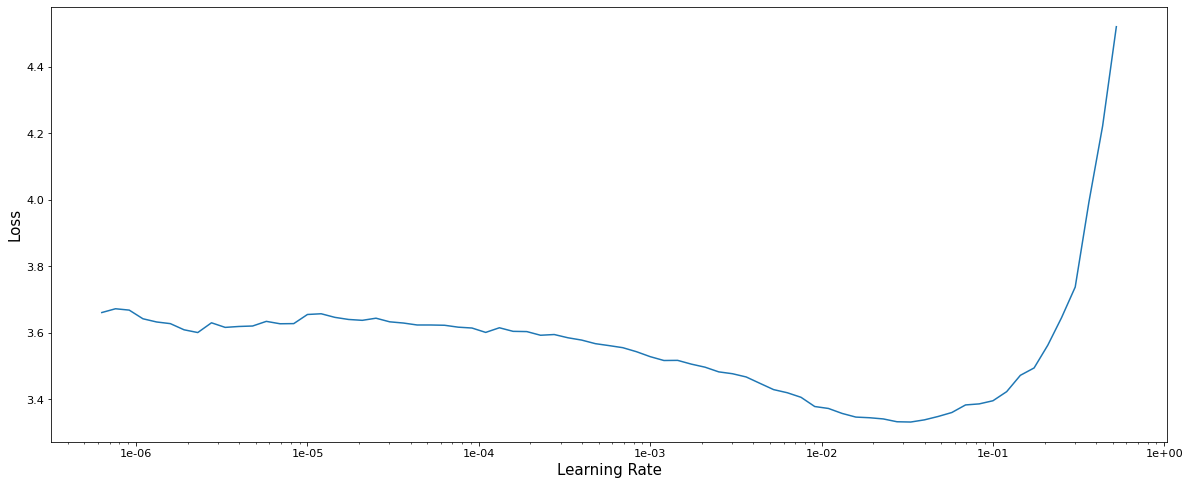

In [0]:
learn = cnn_learner(data, models.resnet34, pretrained=False, metrics=[accuracy]).mixup()
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(25, 2e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.961344,2.349468,0.230828,00:58
1,2.531698,1.951521,0.367898,00:59
2,2.271944,1.998399,0.329682,00:59
3,2.168869,2.004102,0.335032,00:59
4,2.008455,1.895648,0.419363,00:58
5,1.794819,1.696992,0.459363,00:59
6,2.029247,1.911778,0.384713,00:58
7,1.971104,3.085157,0.463949,00:58
8,1.889062,3.084694,0.513376,00:58
9,1.646418,1.220643,0.611210,00:58


In [0]:
learn.fit_one_cycle(30, slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.104800,0.640081,0.801019,00:58
1,1.111511,0.644931,0.804331,00:58
2,1.087906,0.636661,0.805096,00:57
3,1.103587,0.636863,0.807134,00:57
4,1.122391,0.649391,0.809172,00:56
5,1.114437,0.637609,0.804586,00:58
6,1.112017,0.633510,0.803567,00:58
7,1.103184,0.614714,0.810191,00:58
8,1.096661,0.635788,0.808662,00:58
9,1.065768,0.612262,0.811210,00:58


In [0]:
learn.fit_one_cycle(5, slice(5e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.964862,0.546925,0.835924,00:57
1,0.976630,0.546082,0.837962,00:57
2,0.981492,0.549365,0.837452,00:56
3,0.967415,0.547152,0.833885,00:57
4,0.976919,0.544612,0.834395,00:57


# xse_resnext

In [0]:
from torch.nn.init import kaiming_uniform_,uniform_,xavier_uniform_,normal_

defaults.activation=nn.ReLU
NormType = Enum('NormType', 'Batch BatchZero Weight Spectral Instance InstanceZero')


class ProdLayer(Module):
    "Merge a shortcut with the result of the module by multiplying them."
    def forward(self, x): return x * x.orig

def _get_norm(prefix, nf, ndim=2, zero=False, **kwargs):
    "Norm layer with `nf` features and `ndim` initialized depending on `norm_type`."
    assert 1 <= ndim <= 3
    bn = getattr(nn, f"{prefix}{ndim}d")(nf, **kwargs)
    if bn.affine:
        bn.bias.data.fill_(1e-3)
        bn.weight.data.fill_(0. if zero else 1.)
    return bn

def BatchNorm(nf, ndim=2, norm_type=NormType.Batch, **kwargs):
    "BatchNorm layer with `nf` features and `ndim` initialized depending on `norm_type`."
    return _get_norm('BatchNorm', nf, ndim, zero=norm_type==NormType.BatchZero, **kwargs)

def init_linear(m, act_func=None, init='auto', bias_std=0.01):
    if getattr(m,'bias',None) is not None and bias_std is not None:
        if bias_std != 0: normal_(m.bias, 0, bias_std)
        else: m.bias.data.zero_()
    if init=='auto':
        if act_func in (F.relu_,F.leaky_relu_): init = kaiming_uniform_
        else: init = getattr(act_func.__class__, '__default_init__', None)
        if init is None: init = getattr(act_func, '__default_init__', None)
    if init is not None: init(m.weight)


def _conv_func(ndim=2, transpose=False):
    "Return the proper conv `ndim` function, potentially `transposed`."
    assert 1 <= ndim <=3
    return getattr(nn, f'Conv{"Transpose" if transpose else ""}{ndim}d')


class ConvLayer(nn.Sequential):
    "Create a sequence of convolutional (`ni` to `nf`), ReLU (if `use_activ`) and `norm_type` layers."
    def __init__(self, ni, nf, ks=3, stride=1, padding=None, bias=None, ndim=2, norm_type=NormType.Batch, bn_1st=True,
                 act_cls=defaults.activation, transpose=False, init='auto', xtra=None, bias_std=0.01, **kwargs):
        if padding is None: padding = ((ks-1)//2 if not transpose else 0)
        bn = norm_type in (NormType.Batch, NormType.BatchZero)
        inn = norm_type in (NormType.Instance, NormType.InstanceZero)
        if bias is None: bias = not (bn or inn)
        conv_func = _conv_func(ndim, transpose=transpose)
        conv = conv_func(ni, nf, kernel_size=ks, bias=bias, stride=stride, padding=padding, **kwargs)
        act = None if act_cls is None else act_cls()
        init_linear(conv, act, init=init, bias_std=bias_std)
        if   norm_type==NormType.Weight:   conv = weight_norm(conv)
        elif norm_type==NormType.Spectral: conv = spectral_norm(conv)
        layers = [conv]
        act_bn = []
        if act is not None: act_bn.append(act)
        if bn: act_bn.append(BatchNorm(nf, norm_type=norm_type, ndim=ndim))
        if inn: act_bn.append(InstanceNorm(nf, norm_type=norm_type, ndim=ndim))
        if bn_1st: act_bn.reverse()
        layers += act_bn
        if xtra: layers.append(xtra)
        super().__init__(*layers)


def AvgPool(ks=2, stride=None, padding=0, ndim=2, ceil_mode=False):
    "nn.AvgPool layer for `ndim`"
    assert 1 <= ndim <= 3
    return getattr(nn, f"AvgPool{ndim}d")(ks, stride=stride, padding=padding, ceil_mode=ceil_mode)


def MaxPool(ks=2, stride=None, padding=0, ndim=2, ceil_mode=False):
    "nn.MaxPool layer for `ndim`"
    assert 1 <= ndim <= 3
    return getattr(nn, f"MaxPool{ndim}d")(ks, stride=stride, padding=padding)


def SEModule(ch, reduction, act_cls=defaults.activation):
    nf = math.ceil(ch//reduction/8)*8
    return SequentialEx(nn.AdaptiveAvgPool2d(1),
                        ConvLayer(ch, nf, ks=1, norm_type=None, act_cls=act_cls),
                        ConvLayer(nf, ch, ks=1, norm_type=None, act_cls=nn.Sigmoid),
                        ProdLayer())


class ResBlock(Module):
    "Resnet block from `ni` to `nh` with `stride`"
    
    def __init__(self, expansion, ni, nf, stride=1, groups=1, reduction=None, nh1=None, nh2=None, dw=False, g2=1,
                 sa=False, sym=False, norm_type=NormType.Batch, act_cls=defaults.activation, ndim=2, ks=3,
                 pool=AvgPool, pool_first=True, **kwargs):
        norm2 = (NormType.BatchZero if norm_type==NormType.Batch else
                 NormType.InstanceZero if norm_type==NormType.Instance else norm_type)
        if nh2 is None: nh2 = nf
        if nh1 is None: nh1 = nh2
        nf,ni = nf*expansion,ni*expansion
        k0 = dict(norm_type=norm_type, act_cls=act_cls, ndim=ndim, **kwargs)
        k1 = dict(norm_type=norm2, act_cls=None, ndim=ndim, **kwargs)
        convpath  = [ConvLayer(ni,  nh2, ks, stride=stride, groups=ni if dw else groups, **k0),
                     ConvLayer(nh2,  nf, ks, groups=g2, **k1)
        ] if expansion == 1 else [
                     ConvLayer(ni,  nh1, 1, **k0),
                     ConvLayer(nh1, nh2, ks, stride=stride, groups=nh1 if dw else groups, **k0),
                     ConvLayer(nh2,  nf, 1, groups=g2, **k1)]
        if reduction: convpath.append(SEModule(nf, reduction=reduction, act_cls=act_cls))
        if sa: convpath.append(SimpleSelfAttention(nf,ks=1,sym=sym))
        self.convpath = nn.Sequential(*convpath)
        idpath = []
        if ni!=nf: idpath.append(ConvLayer(ni, nf, 1, act_cls=None, ndim=ndim, **kwargs))
        if stride!=1: idpath.insert((1,0)[pool_first], pool(2, ndim=ndim, ceil_mode=True))
        self.idpath = nn.Sequential(*idpath)
        self.act = defaults.activation(inplace=True) if act_cls is defaults.activation else act_cls()

    def forward(self, x): return self.act(self.convpath(x) + self.idpath(x))


def SEResNeXtBlock(expansion, ni, nf, groups=32, reduction=16, stride=1, base_width=4, **kwargs):
    w = math.floor(nf * (base_width / 64)) * groups
    return ResBlock(expansion, ni, nf, stride=stride, groups=groups, reduction=reduction, nh2=w, **kwargs)

def init_cnn(m):
    if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d,nn.Linear)): nn.init.kaiming_normal_(m.weight)
    for l in m.children(): init_cnn(l)

class XResNet(nn.Sequential):
    
    def __init__(self, block, expansion, layers, p=0.0, c_in=3, n_out=1000, stem_szs=(32,32,64),
                 widen=1.0, sa=False, act_cls=defaults.activation, **kwargs):
        # store_attr(self, 'block,expansion,act_cls')
        self.block = block
        self.expansion = expansion
        self.act_cls = act_cls
        stem_szs = [c_in, *stem_szs]
        stem = [ConvLayer(stem_szs[i], stem_szs[i+1], stride=2 if i==0 else 1, act_cls=act_cls)
                for i in range(3)]

        block_szs = [int(o*widen) for o in [64,128,256,512] +[256]*(len(layers)-4)]
        block_szs = [64//expansion] + block_szs
        blocks    = self._make_blocks(layers, block_szs, sa, **kwargs)

        super().__init__(
            *stem, nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *blocks,
            nn.AdaptiveAvgPool2d(1), Flatten(), nn.Dropout(p),
            nn.Linear(block_szs[-1]*expansion, n_out),
        )
        init_cnn(self)

    def _make_blocks(self, layers, block_szs, sa, **kwargs):
        return [self._make_layer(ni=block_szs[i], nf=block_szs[i+1], blocks=l,
                                 stride=1 if i==0 else 2, sa=sa and i==len(layers)-4, **kwargs)
                for i,l in enumerate(layers)]

    def _make_layer(self, ni, nf, blocks, stride, sa, **kwargs):
        return nn.Sequential(
            *[self.block(self.expansion, ni if i==0 else nf, nf, stride=stride if i==0 else 1,
                      sa=sa and i==(blocks-1), act_cls=self.act_cls, **kwargs)
              for i in range(blocks)])


se_kwargs2 = dict(groups=32, reduction=16)
g1 = [3,4,6,3]


def xse_resnext50(pretrained=False, n_out=1000, **kwargs):
    return XResNet(SEResNeXtBlock, 4, g1, n_out=n_out, **se_kwargs2, pool=MaxPool)

In [0]:
data = get_dbunch(128, 0, 64)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

You can deactivate this warning by passing `no_check=True`.


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

In [0]:
learn = cnn_learner(data, xse_resnext50, pretrained=False, metrics=[accuracy]).to_fp16()

In [0]:
learn.fit_one_cycle(40, 8e-3, moms=(0.99, 0.9), wd=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.913642,1.374475,0.571975,01:19
1,1.522162,1.214983,0.633121,01:17
2,1.281797,1.097414,0.658854,01:17
3,1.095261,1.182443,0.648408,01:17
4,0.990329,0.927314,0.712866,01:17
5,0.965280,1.170902,0.691975,01:17
6,0.914424,1.175120,0.649427,01:17
7,0.875965,1.081655,0.681019,01:17
8,0.786909,0.966578,0.717962,01:17
9,0.721391,0.972437,0.705478,01:17


In [0]:
data = get_dbunch(128, 0, 8)

In [0]:
learn = cnn_learner(data, xse_resnext50, pretrained=False, metrics=[accuracy]).to_fp16()

In [0]:
learn.fit_one_cycle(20, 8e-3, moms=(0.99, 0.95), wd=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.885312,1.373805,0.552866,05:13
1,1.671188,1.550284,0.528408,05:10
2,1.602977,1.382118,0.581911,05:11
3,1.425524,1.070668,0.656560,05:10
4,1.311527,1.147527,0.622675,05:11
5,1.314582,0.944717,0.691210,05:11
6,1.213776,0.885974,0.717197,05:10
7,1.217254,5.440495,0.715669,05:11
8,1.197109,38.402473,0.653503,05:11
9,1.124924,17.328543,0.663440,05:10


In [0]:
data = get_dbunch(128, 0, 32)

In [0]:
learn = cnn_learner(data, xse_resnext50, pretrained=False, metrics=[accuracy]).to_fp16()

In [0]:
learn.fit_one_cycle(20, 8e-3, moms=(0.99, 0.95), wd=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.768776,1.267157,0.604076,02:48
1,1.383281,1.132894,0.628790,02:38
2,1.274975,1.131642,0.658089,02:37
3,1.162010,1.562253,0.590828,02:38
4,1.072715,1.628670,0.553631,02:37
5,0.922054,0.886454,0.722038,02:37
6,0.862371,0.775288,0.752357,02:37
7,0.800564,0.683034,0.782420,02:37
8,0.675068,0.663480,0.781401,02:37
9,0.625791,0.653849,0.784204,02:38


In [0]:
data = get_dbunch(128, 0, 128)

In [0]:
learn = cnn_learner(data, xse_resnext50, pretrained=False, metrics=[accuracy]).to_fp16()

In [0]:
learn.fit_one_cycle(20, 8e-3, moms=(0.99, 0.95), wd=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.084009,1.687606,0.511083,02:24
1,1.705092,1.274670,0.612229,02:08
2,1.345273,1.369367,0.608153,02:08
3,1.084277,1.161852,0.641019,02:08
4,0.951957,1.054350,0.682038,02:08
5,0.920053,1.379431,0.599236,02:08
6,0.827968,1.123997,0.704204,02:08
7,0.732273,0.821175,0.746497,02:07
8,0.681664,0.984082,0.713376,02:07
9,0.614605,0.738377,0.764076,02:07


In [0]:
data = get_dbunch(128, 0, 4)

In [0]:
learn = cnn_learner(data, xse_resnext50, pretrained=False, metrics=[accuracy]).to_fp16()

In [0]:
learn.fit_one_cycle(20, 8e-3, moms=(0.9967, 0.9873), wd=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.378728,1.901820,0.352611,05:13
1,2.020589,1.630940,0.469809,05:12
2,1.913580,1.540032,0.480764,05:16
3,1.794202,1.324574,0.560510,05:20
4,1.978791,8.047211,0.433885,05:21
5,1.974485,34.864449,0.410955,05:22
6,1.967758,25.282167,0.427006,05:22
7,1.822438,116.972099,0.422420,05:19
8,1.746340,9.349159,0.545478,05:15
9,1.628747,10.269149,0.550573,05:15


In [0]:
data = get_dbunch(128, 0, 8)

In [0]:
learn = cnn_learner(data, xse_resnext50, pretrained=False, metrics=[accuracy]).to_fp16()

In [0]:
learn.fit_one_cycle(20, 8e-3, moms=(0.9967, 0.9873), wd=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.956323,1.321047,0.567643,02:55
1,1.554326,1.170902,0.623694,02:54
2,1.664355,1.179262,0.621147,02:56
3,1.384407,1.041565,0.658344,02:55
4,1.272201,0.991526,0.674650,02:54
5,1.222815,0.933458,0.701911,02:54
6,1.281781,1.605036,0.694013,02:53
7,1.119097,2.175301,0.719745,02:53
8,1.229375,7.529914,0.714140,02:53
9,1.046273,8.823804,0.737834,02:54


In [0]:
data = get_dbunch(128, 0, 32)

In [0]:
learn = cnn_learner(data, xse_resnext50, pretrained=False, metrics=[accuracy]).to_fp16()

In [0]:
learn.fit_one_cycle(20, 8e-3, moms=(0.9967, 0.9873), wd=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.855659,1.420622,0.545732,02:47
1,1.415900,1.152840,0.629299,02:37
2,1.138109,0.954080,0.684586,02:37
3,1.210850,1.123442,0.669554,02:38
4,1.020075,0.917402,0.723057,02:38
5,0.949878,0.792480,0.750064,02:37
6,0.869805,0.722584,0.776306,02:38
7,0.818215,0.702842,0.772739,02:37
8,0.691949,0.589722,0.814777,02:37
9,0.650018,0.577457,0.814522,02:37


In [0]:
data = get_dbunch(128, 0, 32)

In [0]:
learn = cnn_learner(data, xse_resnext50, pretrained=False, metrics=[accuracy]).to_fp16()

In [0]:
learn.fit_one_cycle(20, 8e-3, moms=(0.9606, 0.8145), wd=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.789418,1.349036,0.584459,01:35
1,1.498545,1.522184,0.536306,01:34
2,1.290335,1.277546,0.629299,01:34
3,1.194438,1.763449,0.539363,01:34
4,1.061064,0.977445,0.689936,01:35
5,1.000880,0.883639,0.709045,01:35
6,0.858755,0.795793,0.744459,01:35
7,0.783438,0.754931,0.763312,01:35
8,0.721457,0.603504,0.809172,01:35
9,0.660414,0.749214,0.775796,01:35


In [0]:
data = get_dbunch(128, 0, 8)

In [0]:
learn = cnn_learner(data, xse_resnext50, pretrained=False, metrics=[accuracy]).to_fp16()

In [0]:
learn.fit_one_cycle(20, 2e-3, moms=(0.9967, 0.9873), wd=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.979213,1.404911,0.548025,03:44
1,1.694398,1.164476,0.615541,03:39
2,1.522416,1.033800,0.657325,03:40
3,1.362091,1.007033,0.685860,03:39
4,1.123065,0.893330,0.711338,03:39
5,1.186612,0.940662,0.683567,03:39
6,1.000635,0.753674,0.764331,03:39
7,0.914328,0.655456,0.794904,03:39
8,0.906456,0.618366,0.803312,03:38
9,0.803389,0.562468,0.826752,03:39


In [0]:
data = get_dbunch(128, 0, 4)

In [0]:
learn = cnn_learner(data, xse_resnext50, pretrained=False, metrics=[accuracy]).to_fp16()

In [0]:
learn.fit_one_cycle(20, 1e-3, moms=(0.99875, 0.9936), wd=1.25e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.627167,1.608578,0.464713,06:46
1,2.192635,1.537334,0.487134,06:42
2,2.054130,1.378969,0.549045,06:42
3,1.709666,1.191434,0.614777,06:42
4,1.484516,1.014107,0.669554,06:41
5,1.438837,0.982573,0.687643,06:40
6,1.401859,0.918874,0.709809,06:41
7,1.223321,0.811719,0.742675,06:40
8,1.151597,0.713331,0.776815,06:40
9,1.035181,0.741302,0.769682,06:39


In [6]:
data = get_dbunch(128, 0, 512)

In [0]:
learn = cnn_learner(data, xse_resnext50, pretrained=False, metrics=[accuracy]).to_fp16()

In [8]:
learn.fit_one_cycle(20, 3.2e-2, moms=(0.9606, 0.8145), wd=4e-2)

epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: ignored

In [0]:
def get_mom(mom, scale):
    return np.exp(np.log(0.5) / (np.log(0.5) / np.log(mom) / scale))
BS = 64
SQ_MOM = 0.99
MOM = 0.95
LR = 8e-3
WD = 1e-2

if not os.path.exists(root_dir / 'results.csv'):
    with open(root_dir / 'results.csv', 'a') as f:
        f.write("bs,lr,wd,mom,sq_mom,loss,acc\n")

for bs in (8, 16, 32, 64, 128, 256, 512):
    if bs < 64:
        scale_offset = 4
    else:
        scale_offset = 1/4
    # for scale_offset in (1/2, 1, 2):
        # if processed > 0:
        #     processed -= 1
        #     continue
    if 'learn' in locals():
        learn.destroy()
    torch.cuda.empty_cache()
    scale = bs / BS * scale_offset
    sq_mom = get_mom(SQ_MOM, scale)
    mom = get_mom(MOM, scale)
    lr = LR * scale
    wd = WD * scale
    data = get_dbunch(128, 0, bs)
    learn = cnn_learner(data, xse_resnext50, pretrained=False, metrics=[accuracy]).to_fp16()
    learn.fit_one_cycle(20, lr, moms=(sq_mom, mom), wd=wd)
    results = learn.validate(metrics=[accuracy])
    text = ",".join([str(bs), str(lr), str(wd), str(mom), str(sq_mom), str(results[0]), str(float(results[1]))])
    print(text)
    with open(root_dir / 'results.csv', 'a') as f:
        f.write(text + "\n")

epoch,train_loss,valid_loss,accuracy,time
0,2.148340,1.337110,0.559490,05:20
1,1.658803,1.241669,0.591847,05:12
2,1.554302,1.270984,0.587261,05:13
3,1.480149,1.158797,0.625223,05:12
4,1.244071,0.912807,0.704204,05:12
5,1.134035,0.848002,0.728408,05:12
6,1.155567,0.725658,0.770955,05:13
7,0.968621,0.635749,0.800000,05:12
8,0.941565,0.646468,0.794395,05:13
9,0.802049,0.552655,0.821146,05:13


8,0.004,0.005,0.9746794344808963,0.99498743710662,0.36231,0.8863694071769714


77

this Learner object self-destroyed - it still exists, but no longer usable


epoch,train_loss,valid_loss,accuracy,time
0,1.911116,1.380776,0.560510,03:31
1,1.494930,1.166571,0.617580,03:24
2,1.384235,1.142190,0.645096,03:24


# Models definition

In [0]:
from torchvision.models.resnet import BasicBlock, conv1x1, conv3x3
from IPython.core.debugger import set_trace

class MiniNet(nn.Module):

    def __init__(self, inchannels, outchannels, nano=False):
        super().__init__()
        self.inplanes = max(inchannels, 16)
        norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer
        self.dilation = 1
        self.groups = 1
        self.base_width = 64
        self.nano = nano
        
        if not self.nano:
            self.conv1 = nn.Conv2d(inchannels, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
            self.bn1 = nn.BatchNorm2d(self.inplanes)
            self.relu = nn.ReLU(inplace=True)
            self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            self.layer1 = self._make_layer(BasicBlock, max(inchannels, 64), 1, stride=2)
            self.layer2 = self._make_layer(BasicBlock, max(inchannels, 128), 1, stride=2)
            self.layer3 = self._make_layer(BasicBlock, max(inchannels, 256), 1, stride=2)
            self.layer4 = self._make_layer(BasicBlock, max(inchannels, 512), 1, stride=2)
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
            self.fc = nn.Linear(max(inchannels, 512), outchannels)
        else:
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
            self.fc = nn.Linear(inchannels, outchannels)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        if not self.nano:
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
            x = self.maxpool(x)

            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)
            x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)


class LSTMBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, mininet, stride=1, downsample=None,
                 add=1, concat=0, memory_width=1, cell_num=0):
        super(LSTMBlock, self).__init__()
        self.cell_num = cell_num

        self.inplanes = inplanes
        self.ih = mininet

        self.concat = concat
        self.memory_width = memory_width
        self.add = add
        self.expansion = 1 + (self.concat * (self.memory_width - self.add))

        norm_layer = nn.BatchNorm2d
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes * self.expansion, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        if x.shape[1] == self.inplanes:
            h = torch.cat([x for i in range(self.expansion)], 1)
            c = torch.cat([x for i in range(self.memory_width)], 1)
        else:
            h = x[:, :(self.inplanes*self.expansion)]
            c = x[:, (self.inplanes*self.expansion):]

        out = self.conv1(h)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        gates = (self.ih(h)).chunk(2, 1)
        ingate,forgetgate = map(torch.sigmoid, gates)
        c = torch.transpose(c, 0, 2)
        c = torch.transpose(c, 1, 3)
        h_first = h[:, :self.inplanes]
        h_first = torch.transpose(h_first, 0, 2)
        h_first = torch.transpose(h_first, 1, 3)
        c = (forgetgate*c) + (ingate*torch.cat([h_first] * self.memory_width, 3))
        c = torch.transpose(c, 0, 2)
        c = torch.transpose(c, 1, 3)

        if self.downsample is not None:
            c = self.downsample(c)

        if self.add:
            out = out + c[:, :out.shape[1]]
            if self.concat:
                h = torch.cat((out, c[:, out.shape[1]:]), 1)
            else:
                h = out
        else:
            h = torch.cat((out, c), 1)
        
        h = self.relu(h)

        x = torch.cat((h, c), 1)
        # raise ValueError()
        return x


class LSTMNet(nn.Module):

    def __init__(self, layers, add=1, concat=0, memory_width=1, num_classes=1000, nanonet=False):
        super(LSTMNet, self).__init__()
        norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.memory_width = memory_width
        self.concat = concat
        self.add = add
        if self.add + self.concat < 1:
            return ValueError("Must use at least one of (add, concat)")
        self.inplanes = 64
        self.expansion = 1 + (self.concat * (self.memory_width - self.add))
        self.nanonet = nanonet
        mininets = [MiniNet(self.expansion * self.inplanes, (2 * self.memory_width) * self.inplanes, nano=self.nanonet)]
        self.cell_num = 0

        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(mininets, 64, layers[0])
        self.layer2 = self._make_layer(mininets, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(mininets, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(mininets, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * (self.expansion + self.memory_width), num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def _make_layer(self, mininets, planes, blocks, stride=1):
        block = LSTMBlock
        norm_layer = self._norm_layer
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                conv1x1(self.inplanes * self.memory_width, planes * self.memory_width, stride),
                norm_layer(planes * self.memory_width),
            )

        layers = []
        layers.append(block(self.inplanes, planes, mininets[-1], stride=stride,
                            downsample=downsample, add=self.add, concat=self.concat,
                            memory_width=self.memory_width, cell_num=self.cell_num))
        self.cell_num += 1
        if self.inplanes != planes:
            self.inplanes = planes
            mininets.append(MiniNet(self.expansion * self.inplanes, (2 * self.memory_width) * self.inplanes, nano=self.nanonet))
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, mininets[-1], 
                                add=self.add, concat=self.concat,
                                memory_width=self.memory_width, cell_num=self.cell_num))
            self.cell_num += 1

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


def _lstmnet(layers, **kwargs):
    model = LSTMNet(layers, **kwargs)
    return model


def lstmresnet34(pretrained=False, progress=True, **kwargs):
    return _lstmnet([3, 4, 6, 3], add=1, concat=0, memory_width=1, **kwargs)


def lstmresnet34nano(pretrained=False, progress=True, **kwargs):
    return _lstmnet([3, 4, 6, 3], add=1, concat=0, memory_width=1, nanonet=True, **kwargs)


def lstmdensenet34(pretrained=False, progress=True, **kwargs):
    return _lstmnet([3, 4, 6, 3], add=0, concat=1, memory_width=3, **kwargs)


def lstmdensenet34nano(pretrained=False, progress=True, **kwargs):
    return _lstmnet([3, 4, 6, 3], add=0, concat=1, memory_width=3, nanonet=True, **kwargs)


def lstmconcatnet34(pretrained=False, progress=True, **kwargs):
    return _lstmnet([3, 4, 6, 3], add=1, concat=1, memory_width=1, **kwargs)


def lstmconcatnet34nano(pretrained=False, progress=True, **kwargs):
    return _lstmnet([3, 4, 6, 3], add=1, concat=1, memory_width=1, nanonet=True, **kwargs)


def lstmmixnet34(pretrained=False, progress=True, **kwargs):
    return _lstmnet([3, 4, 6, 3], add=1, concat=1, memory_width=2, **kwargs)


def lstmmixnet34nano(pretrained=False, progress=True, **kwargs):
    return _lstmnet([3, 4, 6, 3], add=1, concat=1, memory_width=2, nanonet=True, **kwargs)


def mininet(pretrained=False, progress=True, num_classes=1000, **kwargs):
    model = MiniNet(3, num_classes, **kwargs)
    return model

In [0]:
class LSTMResBlock(Module):
    "Resnet block from `ni` to `nf` with `stride`"
    
    def __init__(self, expansion, ni, nf, stride=1, groups=1, reduction=None, nh1=None, nh2=None, dw=False, g2=1,
                 sa=False, sym=False, norm_type=NormType.Batch, act_cls=defaults.activation, ndim=2, ks=3,
                 pool=AvgPool, pool_first=True, add=1, concat=0, memory_width=1, cell_num=0, mininet=None, **kwargs):
        
        self.cell_num = cell_num
        
        if nh2 is None: nh2 = nf
        if nh1 is None: nh1 = nh2
        nf,ni = nf*expansion,ni*expansion

        self.inplanes = ni
        self.planes = nf

        self.concat = concat
        self.memory_width = memory_width
        self.add = add
        self.lstm_expansion = 1 + (self.concat * (self.memory_width - self.add))
        if mininet is None:
            mininet = MiniNet(self.expansion * self.inplanes, (2 * self.memory_width) * self.inplanes, nano=True)
        self.ih = mininet

        ni *= self.lstm_expansion
        norm2 = (NormType.BatchZero if norm_type==NormType.Batch else
                 NormType.InstanceZero if norm_type==NormType.Instance else norm_type)
        
        k0 = dict(norm_type=norm_type, act_cls=act_cls, ndim=ndim, **kwargs)
        k1 = dict(norm_type=norm2, act_cls=None, ndim=ndim, **kwargs)
        convpath  = [ConvLayer(ni,  nh2, ks, stride=stride, groups=ni if dw else groups, **k0),
                     ConvLayer(nh2,  nf, ks, groups=g2, **k1)
        ] if expansion == 1 else [
                     ConvLayer(ni,  nh1, 1, **k0),
                     ConvLayer(nh1, nh2, ks, stride=stride, groups=nh1 if dw else groups, **k0),
                     ConvLayer(nh2,  nf, 1, groups=g2, **k1)]
        if reduction: convpath.append(SEModule(nf, reduction=reduction, act_cls=act_cls))
        if sa: convpath.append(SimpleSelfAttention(nf,ks=1,sym=sym))
        self.convpath = nn.Sequential(*convpath)
        idpath = []
        if ni!=nf: idpath.append(ConvLayer(ni, nf, 1, act_cls=None, ndim=ndim, **kwargs))
        if stride!=1: idpath.insert((1,0)[pool_first], pool(2, ndim=ndim, ceil_mode=True))
        self.idpath = nn.Sequential(*idpath)
        self.act = defaults.activation(inplace=True) if act_cls is defaults.activation else act_cls()

    def forward(self, x):
        if x.shape[1] == self.inplanes:
            h = torch.cat([x for i in range(self.lstm_expansion)], 1)
            c = torch.cat([x for i in range(self.memory_width)], 1)
        else:
            h = x[:, :(self.inplanes*self.lstm_expansion)]
            c = x[:, (self.inplanes*self.lstm_expansion):]

        out = self.convpath(h)

        gates = (self.ih(h)).chunk(2, 1)
        ingate,forgetgate = map(torch.sigmoid, gates)
        c = torch.transpose(c, 0, 2)
        c = torch.transpose(c, 1, 3)
        h_first = h[:, :self.inplanes]
        h_first = torch.transpose(h_first, 0, 2)
        h_first = torch.transpose(h_first, 1, 3)
        c = (forgetgate*c) + (ingate*torch.cat([h_first] * self.memory_width, 3))
        c = torch.transpose(c, 0, 2)
        c = torch.transpose(c, 1, 3)

        c = self.idpath(c)

        if self.add:
            out = out + c[:, :out.shape[1]]
            if self.concat:
                h = torch.cat((out, c[:, out.shape[1]:]), 1)
            else:
                h = out
        else:
            h = torch.cat((out, c), 1)
        
        h = self.act(h)

        x = torch.cat((h, c), 1)
        
        return x


def LSTMSEResNeXtBlock(expansion, ni, nf, groups=32, reduction=16, stride=1, base_width=4, **kwargs):
    w = math.floor(nf * (base_width / 64)) * groups
    return LSTMResBlock(expansion, ni, nf, stride=stride, groups=groups, reduction=reduction, nh2=w, **kwargs)


class LSTMXResNet(nn.Sequential):
    
    def __init__(self, block, expansion, layers, p=0.0, c_in=3, n_out=1000, stem_szs=(32,32,64),
                 widen=1.0, sa=False, act_cls=defaults.activation, add=1, concat=0, memory_width=1, nanonet=True, **kwargs):
        
        self.memory_width = memory_width
        self.concat = concat
        self.add = add
        if self.add + self.concat < 1:
            return ValueError("Must use at least one of (add, concat)")
        self.inplanes = 64
        self.lstm_expansion = 1 + (self.concat * (self.memory_width - self.add))
        self.nanonet = nanonet
        self.mininets = [MiniNet(self.lstm_expansion * self.inplanes, (2 * self.memory_width) * self.inplanes, nano=self.nanonet)]
        self.cell_num = 0

        self.block = block
        self.expansion = expansion
        self.act_cls = act_cls
        stem_szs = [c_in, *stem_szs]
        stem = [ConvLayer(stem_szs[i], stem_szs[i+1], stride=2 if i==0 else 1, act_cls=act_cls)
                for i in range(3)]

        block_szs = [int(o*widen) for o in [64,128,256,512] +[256]*(len(layers)-4)]
        block_szs = [64//expansion] + block_szs
        blocks    = self._make_blocks(layers, block_szs, sa, **kwargs)

        super().__init__(
            *stem, nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *blocks,
            nn.AdaptiveAvgPool2d(1), Flatten(), nn.Dropout(p),
            nn.Linear(block_szs[-1]*expansion*(self.lstm_expansion + self.memory_width), n_out),
        )
        init_cnn(self)

    def _make_blocks(self, layers, block_szs, sa, **kwargs):
        ret_layers = []
        for i,l in enumerate(layers):
            if block_szs[i] != block_szs[i+1]:
                self.inplanes = block_szs[i+1] * self.expansion
                self.mininets.append(MiniNet(self.lstm_expansion * self.inplanes, (2 * self.memory_width) * self.inplanes, nano=self.nanonet))
            ret_layers.append(self._make_layer(ni=block_szs[i], nf=block_szs[i+1], blocks=l,
                                 stride=1 if i==0 else 2, sa=sa and i==len(layers)-4, **kwargs))
            self.cell_num += l

        return ret_layers
        # return [self._make_layer(ni=block_szs[i], nf=block_szs[i+1], blocks=l,
        #                          stride=1 if i==0 else 2, sa=sa and i==len(layers)-4, **kwargs)
        #         for i,l in enumerate(layers)]

    def _make_layer(self, ni, nf, blocks, stride, sa, **kwargs):
        return nn.Sequential(
            *[self.block(self.expansion, ni if i==0 else nf, nf, stride=stride if i==0 else 1,
                      sa=sa and i==(blocks-1), act_cls=self.act_cls,
                      mininet=self.mininets[-2] if i==0 else self.mininets[-1],
                      add=self.add, concat=self.concat, memory_width=self.memory_width,
                      cell_num=self.cell_num + i, **kwargs)
              for i in range(blocks)])


se_kwargs2 = dict(groups=32, reduction=16)
g1 = [3,4,6,3]


def lstm_xse_resnext50(pretrained=False, n_out=1000, **kwargs):
    return LSTMXResNet(LSTMSEResNeXtBlock, 4, g1, n_out=n_out, **se_kwargs2, pool=MaxPool)

In [0]:
learn = cnn_learner(data, lstm_xse_resnext50, pretrained=False, metrics=[accuracy]).to_fp16()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

In [0]:
%debug

In [0]:
print(self.cell_num)
print(x.shape, h.shape, c.shape, out.shape)
print(self.memory_width, self.add, self.expansion)
print(self.inplanes)

# LSTMResNet

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


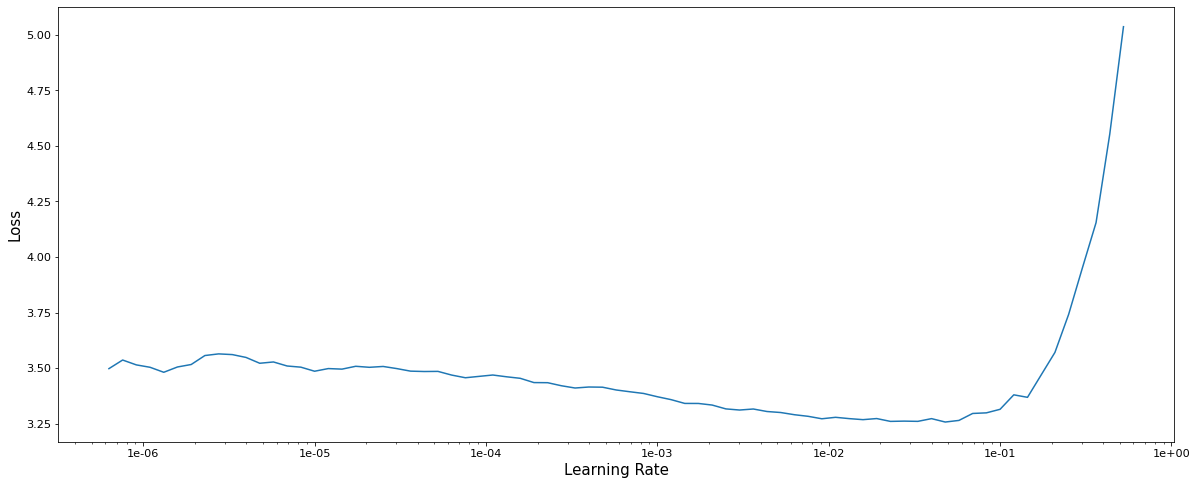

In [0]:
learn = cnn_learner(data, lstmresnet34, pretrained=False, metrics=[accuracy]).mixup()
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(25, 2e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.981677,2.384201,0.196688,01:09
1,2.733057,2.292110,0.172229,01:08
2,2.531713,2.088093,0.269045,01:09
3,2.360314,1.947796,0.319490,01:08
4,2.207868,1.835755,0.390828,01:08
5,2.314759,2.916333,0.199490,01:08
6,2.172851,1.894619,0.376051,01:08
7,2.082895,2.859863,0.271847,01:09
8,1.869475,1.520555,0.482293,01:08
9,1.849571,1.623826,0.497834,01:09


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


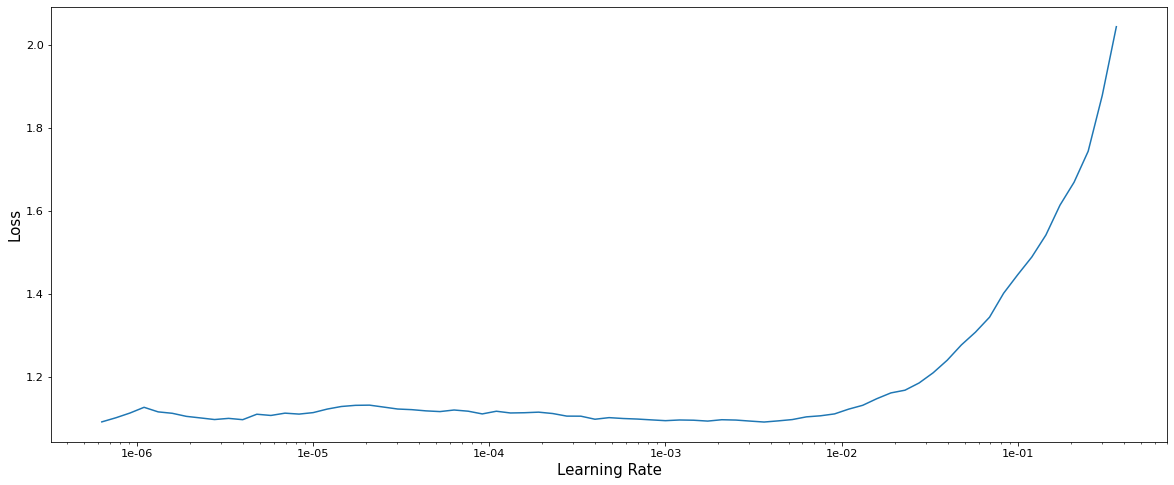

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(30, slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.107234,0.648921,0.801274,01:12
1,1.093347,0.647876,0.801783,01:14
2,1.093638,0.654945,0.800000,01:12
3,1.086203,0.650309,0.797962,01:12
4,1.081093,0.646676,0.799745,01:12
5,1.085042,0.654722,0.797707,01:12
6,1.087065,0.651923,0.799236,01:12
7,1.090169,0.655107,0.795159,01:12
8,1.099992,0.641523,0.805096,01:11
9,1.102288,0.639784,0.803822,01:10


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


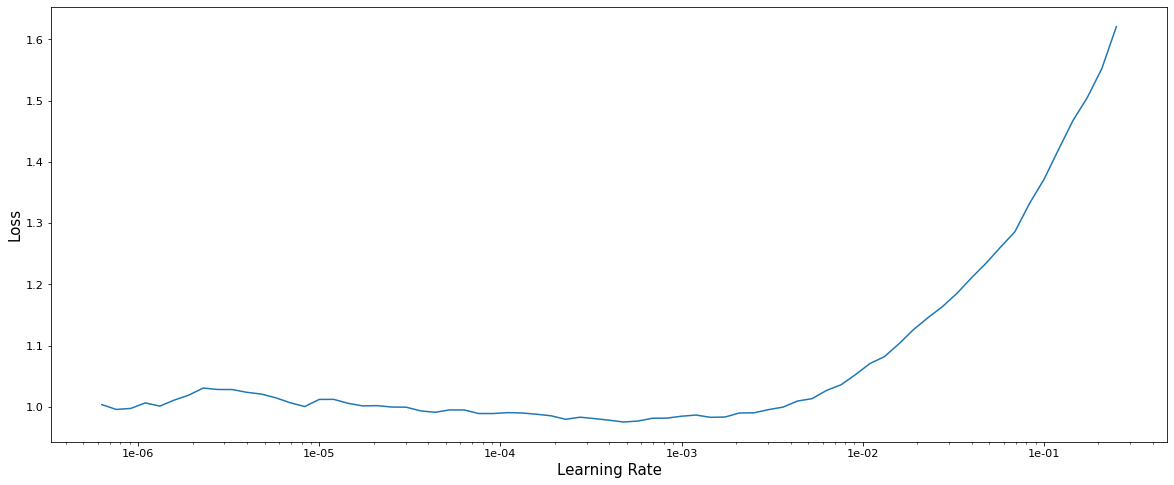

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, slice(5e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.001343,0.586309,0.817580,01:10
1,0.992691,0.587282,0.816561,01:09
2,0.994647,0.584603,0.818089,01:10
3,0.990861,0.582761,0.819108,01:09
4,1.010120,0.585981,0.818089,01:09


# LSTMResNet34nano

In [0]:
data = get_dbunch(128, 0, 64)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


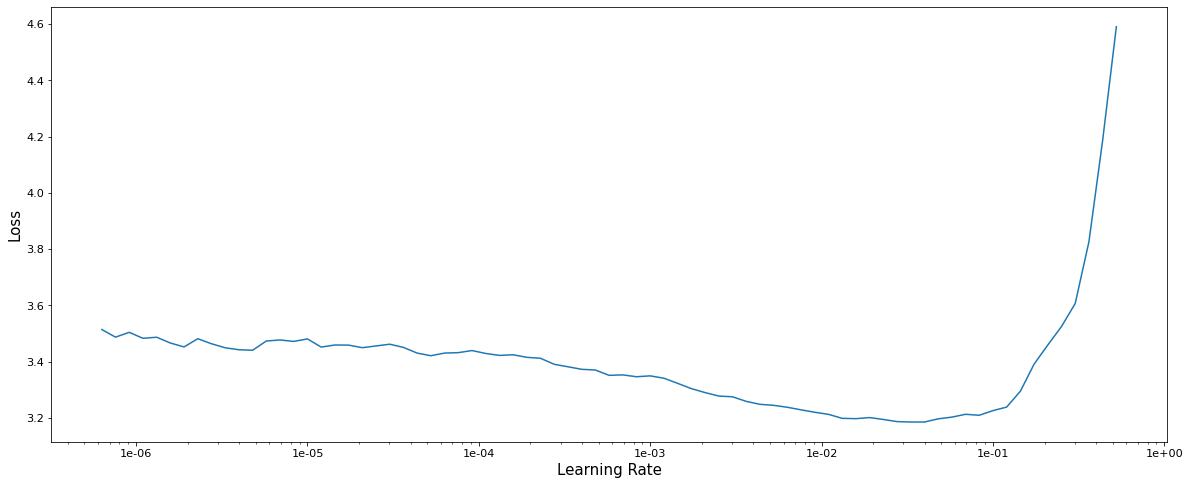

In [0]:
learn = cnn_learner(data, lstmresnet34nano, pretrained=False, metrics=[accuracy]).mixup()
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(25, 2e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.701486,2.192936,0.346242,00:59
1,2.438922,2.282772,0.397197,01:00
2,2.236100,1.739813,0.422420,00:59
3,2.173430,2.140337,0.290446,00:59
4,2.070387,2.189289,0.356943,00:59
5,1.898841,1.820401,0.453758,00:59
6,1.859090,1.378963,0.549554,00:59
7,1.713037,1.451553,0.519745,00:59
8,1.670819,5.546722,0.468025,00:58
9,1.623184,1.343103,0.557962,01:00


In [0]:
learn.fit_one_cycle(30, slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.012864,0.538093,0.833121,00:59
1,1.010276,0.536902,0.834140,00:59
2,1.011201,0.542005,0.835159,00:59
3,1.006173,0.534217,0.836178,00:58
4,0.997546,0.536850,0.834140,00:58
5,0.989597,0.536589,0.834650,00:58
6,0.988176,0.542900,0.835414,00:58
7,0.988191,0.538265,0.833376,00:58
8,0.989202,0.530676,0.833631,00:59
9,0.993135,0.537721,0.836943,00:59


# LSTMMixNet34nano

In [0]:
data = get_dbunch(128, 0, 64)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


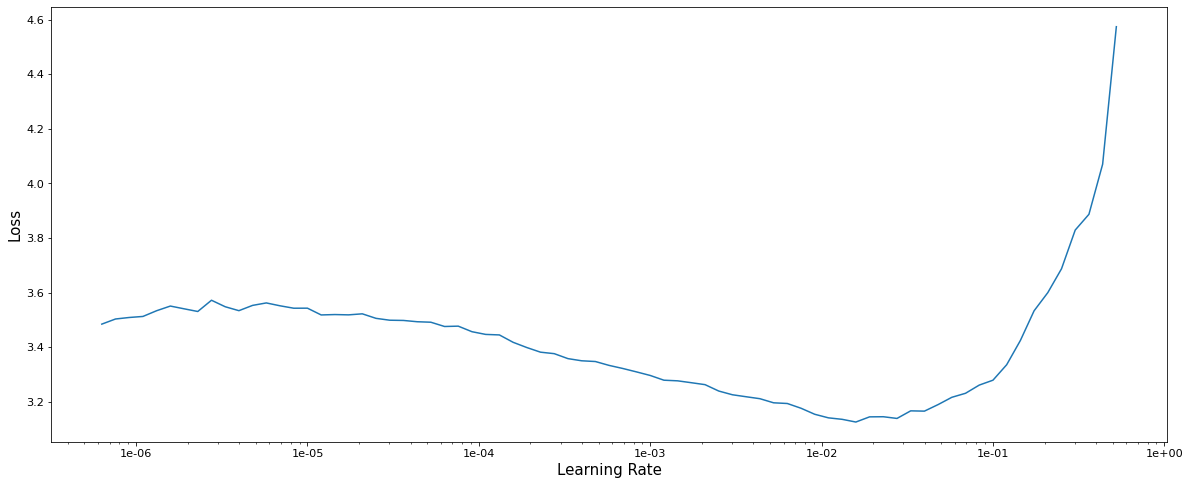

In [0]:
learn = cnn_learner(data, lstmmixnet34nano, pretrained=False, metrics=[accuracy]).mixup()
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(25, 2e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.639982,2.026635,0.351847,00:59
1,2.243017,1.865822,0.435414,00:58
2,2.016912,1.512366,0.507261,00:58
3,1.803417,1.589340,0.482293,00:58
4,1.941717,1.894497,0.416306,00:57
5,2.034955,1.856616,0.401529,00:58
6,1.718581,1.261654,0.594395,00:58
7,1.602179,1.391910,0.617834,00:58
8,1.537269,1.593729,0.621147,00:58
9,1.454773,1.016460,0.668025,00:58


In [0]:
learn.fit_one_cycle(30, slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.983212,0.519536,0.841274,00:58
1,0.978436,0.514287,0.841019,00:58
2,0.968944,0.517512,0.838981,00:58
3,0.982809,0.519798,0.840255,00:58
4,0.964847,0.523832,0.838217,00:59
5,0.965791,0.517147,0.841019,00:58
6,0.963530,0.515547,0.845605,00:57
7,0.966543,0.513082,0.843057,00:58
8,0.978118,0.518211,0.844076,00:58
9,0.966731,0.525300,0.843822,00:57


# LSTMConcatNet34nano

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


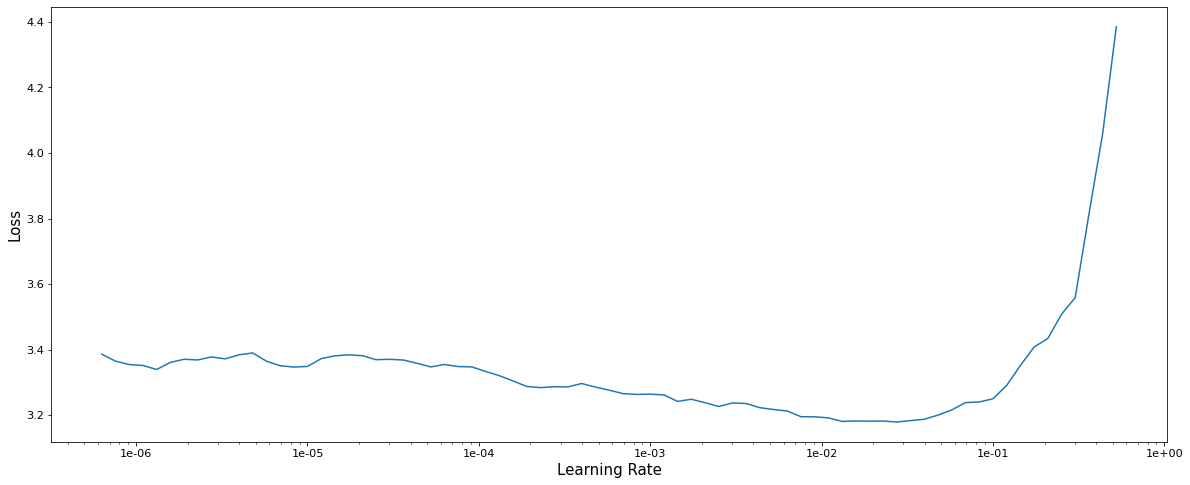

In [0]:
learn = cnn_learner(data, lstmconcatnet34nano, pretrained=False, metrics=[accuracy]).mixup()
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(25, 2e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.747129,2.445747,0.311083,00:59
1,2.442966,2.193651,0.373503,01:00
2,2.253320,2.091524,0.425987,00:59
3,1.998206,2.186148,0.407389,01:01
4,1.929563,2.666466,0.378344,01:00
5,1.710588,1.463234,0.525605,01:00
6,1.850044,1.361483,0.540127,00:59
7,1.745310,1.444345,0.523312,00:59
8,1.638176,1.670558,0.454268,00:59
9,1.570849,1.283938,0.630828,00:59


In [0]:
learn.fit_one_cycle(30, slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.987229,0.519512,0.844331,00:59
1,0.971052,0.517907,0.846879,00:58
2,0.991169,0.515684,0.848153,00:58
3,0.979169,0.514058,0.845096,00:59
4,1.008719,0.514915,0.845605,00:59
5,0.980973,0.517804,0.844586,00:59
6,0.978969,0.521376,0.842293,00:59
7,0.980159,0.523535,0.840764,00:59
8,0.987850,0.521045,0.841529,00:59
9,0.977435,0.534215,0.839236,00:59


# LSTMConcatNet

In [0]:
data = get_dbunch(128, 0, 64)

In [0]:
learn = cnn_learner(data, lstmconcatnet34nano, pretrained=False, metrics=[accuracy]).mixup()
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(15, 2e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.899745,2.243966,0.209936,01:15
1,2.571549,1.993171,0.308535,01:15
2,2.415280,1.909496,0.325350,01:14
3,2.266464,1.797495,0.368917,01:15
4,2.172912,1.736773,0.409427,01:14
5,2.058546,1.805158,0.392357,01:14
6,2.372169,2.327085,0.213503,01:15
7,2.266295,1.925125,0.330701,01:14
8,2.089309,1.795787,0.383694,01:15
9,1.955372,1.577394,0.476688,01:15


In [0]:
learn.fit_one_cycle(20, slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.581506,1.239744,0.600000,01:15
1,1.577104,1.239758,0.600000,01:15
2,1.563732,1.210416,0.616306,01:15
3,1.552642,1.196578,0.616051,01:15
4,1.544525,1.192945,0.612739,01:15
5,1.546293,1.172681,0.619363,01:15
6,1.509734,1.159344,0.628280,01:14
7,1.474326,1.114274,0.642038,01:14
8,1.488268,1.104136,0.646624,01:14
9,1.447253,1.101180,0.645350,01:15


In [0]:
learn.fit_one_cycle(30, slice(5e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.323654,0.988108,0.685096,01:15
1,1.334474,0.983738,0.687643,01:15
2,1.336206,0.988693,0.682038,01:15
3,1.344552,0.983142,0.684586,01:16
4,1.320990,0.976092,0.690955,01:15
5,1.326202,0.981840,0.685605,01:15
6,1.323859,0.979372,0.687134,01:15
7,1.318737,0.974760,0.688917,01:15
8,1.337524,0.972350,0.689936,01:15
9,1.322489,0.977089,0.688917,01:16


# LSTMDenseNet34Nano

In [0]:
data = get_dbunch(128, 0, 64)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


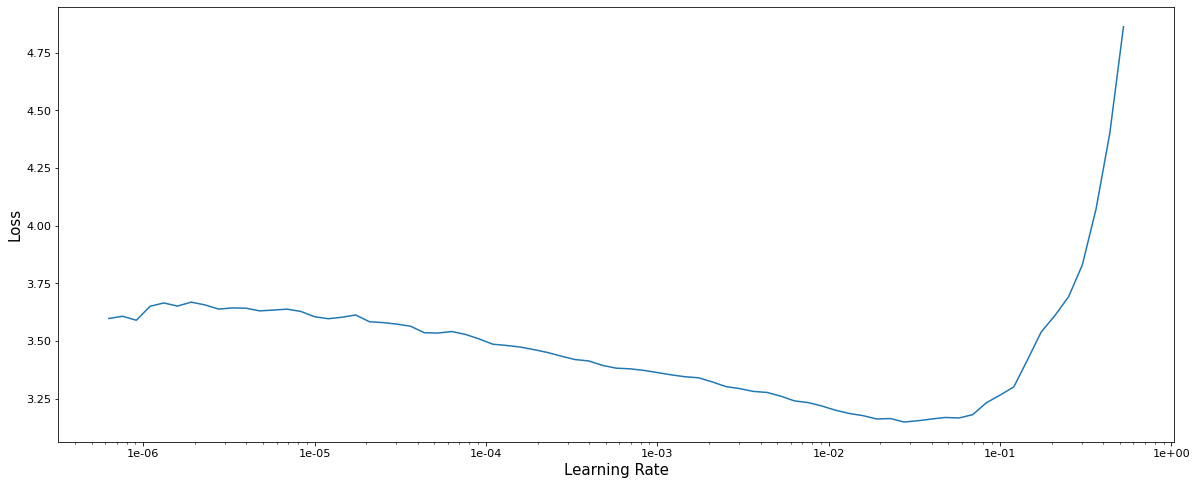

In [0]:
learn = cnn_learner(data, lstmdensenet34nano, pretrained=False, metrics=[accuracy]).mixup()
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(25, 2e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.780082,2.603724,0.272611,01:01
1,2.406668,3.011452,0.375287,01:00
2,2.194596,1.871959,0.397707,01:00
3,2.076516,3.239955,0.396433,01:00
4,1.968244,5.029278,0.380892,01:00
5,2.250775,2.479738,0.303949,01:00
6,1.978157,1.414786,0.535287,01:01
7,1.755957,1.578659,0.488153,01:01
8,1.738000,1.409356,0.559490,01:01
9,1.564522,1.173609,0.619618,01:02


In [0]:
learn.fit_one_cycle(30, slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.012132,0.553545,0.831338,01:05
1,0.998628,0.552545,0.828535,01:05
2,1.014220,0.553443,0.831083,01:05
3,1.021509,0.556529,0.827771,01:05
4,1.016373,0.558117,0.829045,01:05
5,1.032355,0.563525,0.822420,01:05
6,1.023519,0.561959,0.827006,01:03
7,1.021769,0.567867,0.826497,01:04
8,1.022426,0.552086,0.832611,01:05
9,1.005983,0.720308,0.819618,01:06


# LSTMixNet34

In [0]:
data = get_dbunch(128, 0, 32)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


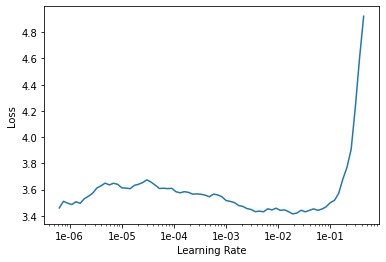

In [0]:
learn = cnn_learner(data, lstmmixnet34, pretrained=False, metrics=[accuracy]).mixup()
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(15, 2e-3, moms=(0.975, 0.925))

epoch,train_loss,valid_loss,accuracy,time
0,2.786232,2.315705,0.219873,02:53
1,2.458764,1.989525,0.308535,02:53
2,2.548135,2.243026,0.185987,02:53
3,2.270992,1.880120,0.351592,02:53
4,2.205778,2.076911,0.313376,02:52
5,1.983751,1.647740,0.440764,02:53
6,1.903980,1.526146,0.494013,02:52
7,1.783890,1.393389,0.540892,02:51
8,1.732124,1.388109,0.542166,02:51
9,1.621047,1.278329,0.580127,02:51


In [0]:
learn.fit_one_cycle(20, slice(1e-4, 1e-3), moms=(0.975, 0.925))

epoch,train_loss,valid_loss,accuracy,time
0,1.397498,0.999322,0.680000,02:51
1,1.393399,0.999092,0.675414,02:52
2,1.411510,0.990638,0.686624,02:53
3,1.414800,1.011562,0.680000,02:53
4,1.438806,0.994436,0.686624,02:52
5,1.397308,0.978754,0.687389,02:52
6,1.418029,0.971017,0.695032,02:51
7,1.373836,0.952131,0.701401,02:51
8,1.349656,0.940913,0.700637,02:53
9,1.339362,0.910714,0.710828,02:51


In [0]:
learn.fit_one_cycle(30, slice(5e-6, 1e-4), moms=(0.975, 0.925))

epoch,train_loss,valid_loss,accuracy,time
0,1.280541,0.880364,0.724841,02:51
1,1.288112,0.858732,0.728662,02:52
2,1.274136,0.856390,0.735032,02:51
3,1.251667,0.857171,0.731975,02:52
4,1.275844,0.873310,0.728662,02:51
5,1.271177,0.850091,0.734013,02:51
6,1.278297,0.859077,0.731210,02:51
7,1.262047,0.865029,0.727898,02:52
8,1.251282,0.855281,0.734777,02:51
9,1.280805,0.901377,0.730955,02:52


Buffered data was truncated after reaching the output size limit.

# LSTM_XSE_XResNet

In [0]:
learn = cnn_learner(data, lstm_xse_resnext50, pretrained=False, metrics=[accuracy]).to_fp16()

In [0]:
learn.fit_one_cycle(40, 8e-3, moms=(0.99, 0.9), wd=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.355305,1.884419,0.429554,01:23
1,1.894476,1.438747,0.553376,01:20
2,1.518395,1.452320,0.552102,01:20
3,1.291001,1.294060,0.600000,01:20
4,1.089636,0.940679,0.696306,01:19
5,1.027169,0.895738,0.712357,01:19
6,0.995414,0.914983,0.707516,01:19
7,0.960231,1.410184,0.612229,01:19
8,0.860713,1.060104,0.683057,01:19
9,0.794909,0.733020,0.774777,01:19


In [0]:
learn = cnn_learner(data, lstm_xse_resnext50, pretrained=False, metrics=[accuracy]).to_fp16()

In [0]:
learn.fit_one_cycle(80, 8e-3, moms=(0.99, 0.9), wd=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.385926,1.969460,0.397962,03:14
1,1.916180,1.493118,0.519490,03:02
2,1.570110,1.320982,0.581656,03:01
3,1.274470,1.228095,0.608662,03:02
4,1.122477,1.023441,0.668535,03:02
5,0.998546,0.932920,0.708280,03:02
6,0.947883,0.881335,0.718726,03:02
7,0.922431,0.841922,0.730446,03:02
8,0.922409,0.870834,0.730446,03:02
9,0.805713,0.760469,0.755924,03:02


Buffered data was truncated after reaching the output size limit.

In [0]:
learn = cnn_learner(data, lstm_xse_resnext50, pretrained=False, metrics=[accuracy]).mixup()

In [0]:
learn.fit_one_cycle(40, 8e-3, moms=(0.99, 0.9), wd=1e-2)

In [0]:
learn = cnn_learner(data, lstm_xse_resnext50, pretrained=False, metrics=[accuracy]).mixup().to_fp16()

In [0]:
learn.fit_one_cycle(40, 8e-3, moms=(0.99, 0.9), wd=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.559334,2.220349,0.333758,01:13
1,2.267127,1.684532,0.452994,01:10
2,1.906879,1.416783,0.545223,01:10
3,1.703669,1.388742,0.579873,01:10
4,1.619382,1.585499,0.653758,01:09
5,1.533293,1.168055,0.633631,01:09
6,1.507232,1.069330,0.654522,01:09
7,1.485464,1.338089,0.696051,01:09
8,1.378741,0.930439,0.708280,01:09
9,1.425500,1.156334,0.644331,01:09
